# Reading Particles + Application to Halo detection with Yt/hop and Halo mass function

Better documentation of the functions in my_hmf_cmf_lib.py


## Libraries

In this notebook we will :
* upload a Dyablo Particle file
* interface with Yt
* create a Halo Catalog, using HOP
* plot the volumic distribution of halo masses in the Universe (aka halo mass function HMF) and compare it to some reference (Meriot & Semelin 2024)
* do the same but in a smaller region of the Universe defined by its overdensity (aka conditionnal mass function CMF)

In [1]:
import numpy as np
import h5py
import yt
import matplotlib.pyplot as plt
import sys, platform, os
from CosmoUtils import *
from yt.extensions.astro_analysis.halo_analysis import HaloCatalog
from tqdm import tqdm
import matplotlib.cm as cm

In [2]:
plt.style.use('stylesheet.mplstyle')

In [3]:
import my_hmf_cmf_lib as mycmf

In [4]:
print(mycmf.TCMB)

2.7255


## Upload Particle file

Let's have a first look at the simulation by plotting the dark matter particles

In [5]:
corr_iter_z = [("0000000", 26.1272),
 ("0000250", 2.47551),
 ("0000500", 1.65828),
 ("0000750", 1.30188),
 ("0001000", 1.04726),
 ("0001250", 0.841156),
 ("0001500", 0.660872),
 ("0001750", 0.509201),
 ("0002000", 0.360715),
 ("0002250", 0.24084),
 ("0002500", 0.140594),
 ("0002750", 0.0389838),
 ("0002850", 0.0)]


nb_iter, zsnap = corr_iter_z[-1]

filename = f"cosmo_particles_particles_iter{nb_iter}.h5"

fpart = h5py.File(f'datastageM2/{filename}', 'r')

positions = np.array(fpart['coordinates'])
print(np.shape(positions))

x=positions[:,0]
y=positions[:,1]
z=positions[:,2]
Npart=np.size(x)


# Uncomment if velocities are available in the Dyablo output
#vx = np.array(fpart['vx'])
#vy = np.array(fpart['vy'])
#vz = np.array(fpart['vz'])

(16777216, 3)


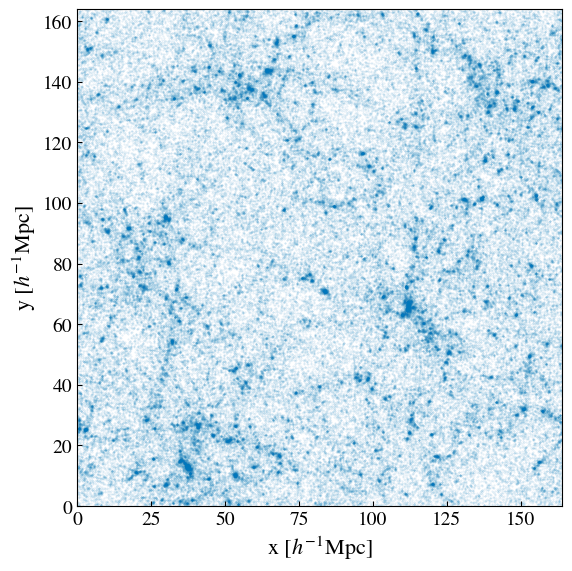

In [6]:
plt.figure(figsize=(6,6))
plt.scatter(x[::100]*164, y[::100]*164, alpha=0.13, s=0.15, rasterized=True)
plt.xlabel("x [$h^{-1}$Mpc]")
plt.ylabel("y [$h^{-1}$Mpc]")
plt.xlim(0,164)
plt.ylim(0,164)
plt.tight_layout()
# plt.savefig(f"./saved_results/misc/particles_{nb_iter}.pdf", dpi=300)
plt.show()

### Some run parameters

In [7]:
L=164 #Mpc/h
H0org=67.00 # km/s/Mpc
om=0.3175 # total density parameter

# Computing the Particle Mass
H0=H0org*1e3/3.086e22
h=H0org/100.
rhoc=3*H0**2/(8*np.pi*6.67e-11) #kg/m^3
rho0 = rhoc * om
mpart=rho0*(L/h*3.086e22)**3/Npart #kg 
mpart_sun = mpart/2e30
print('particle mass [Solar Mass] = {:e}'.format(mpart_sun))

particle mass [Solar Mass] = 3.440346e+10


In [8]:
grid_size = [L/h, L/h, L/h]

In [9]:
print(f"mean density : {rho0:.2e} kg/m^3")

mean density : 2.68e-27 kg/m^3


In [10]:
rho_MsunMpc3 = rho0 / 2e30 * 3.086e22**3 #Msun/Mpc^3
print(f"mean density : {rho_MsunMpc3:.2e} Msun/Mpc^3")

mean density : 3.94e+10 Msun/Mpc^3


## Interfacing with Yt

In [11]:
masses=np.ones(Npart) # dummy particle masses array as a set of unit masses
idx=np.arange(Npart) # monotonic indexes for particles

data = dict(
    particle_position_x=x,
    particle_position_y=y,
    particle_position_z=z,
    particle_velocity_x=x,#dummy with no vel
    particle_velocity_y=y,#dummy with no vel
    particle_velocity_z=z,#dummy with no vel
    particle_mass=masses,
    particle_index=idx
)
ds = yt.load_particles(data,length_unit=L*3.086e24,periodicity=(True,True,True),mass_unit=mpart*1e3)

yt : [INFO     ] 2025-07-16 12:12:16,270 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-07-16 12:12:16,272 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-07-16 12:12:16,274 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-07-16 12:12:16,276 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-07-16 12:12:16,277 Parameters: cosmological_simulation   = 0


## Hop launch (halo finder)

#### Catalog Creation using Hop via Yt

VERY LONG !

In [12]:
# hc = HaloCatalog(data_ds=ds, finder_method="hop",output_dir="./datastageM2/")

In [13]:
# hc.create() # launch in background

In [ ]:
# fhalo = h5py.File('datastageM2/ParticleData/ParticleData.0.h5', 'r') # upload Hop results

fhalo = h5py.File(f'saved_results/data/ParticleData/ParticleData{nb_iter}.h5', 'r') # upload Hop results
# fhalo = h5py.File(f'datastageM2/cosmo_iter0000250.h5', 'r') # upload Hop results

In [15]:
fhalo.keys()

<KeysViewHDF5 ['particle_identifier', 'particle_index_start', 'particle_mass', 'particle_number', 'particle_position_x', 'particle_position_y', 'particle_position_z', 'particle_velocity_x', 'particle_velocity_y', 'particle_velocity_z', 'particles', 'virial_radius']>

In [16]:
xh=np.array(fhalo['particle_position_x']) #HOP halo positions
yh=np.array(fhalo['particle_position_y']) #HOP halo positions
zh=np.array(fhalo['particle_position_z']) #HOP halo positions
mh=np.array(fhalo['particle_mass']) #HOP halo mass

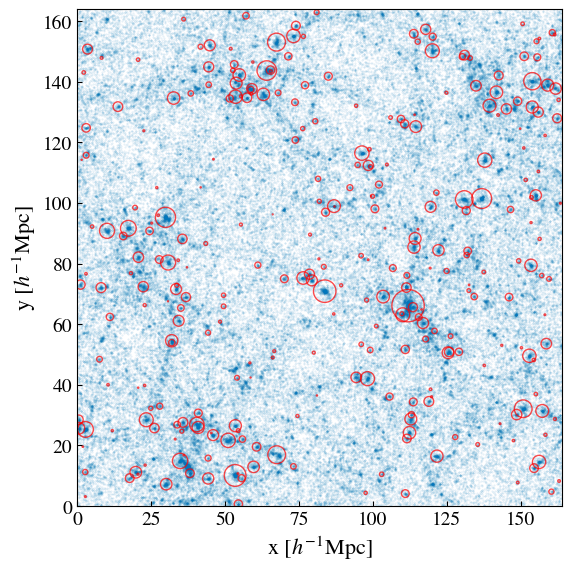

In [17]:
num_points = 450 # number of halos that we'll show, arbitrary
indices = np.unique(np.logspace(0, np.log10(len(xh)-1), num=num_points, dtype=int))

size_mh_full = mh[indices] / mh[0] * 700

plt.figure(figsize=(6,6))
plt.scatter(x[::100]*164, y[::100]*164, alpha=0.13, s=0.15, rasterized=True)
plt.scatter(xh[indices]*164, yh[indices]*164, 
            alpha=0.7, 
            s=size_mh_full,
            color="red",
            facecolors='none',
            rasterized=True)

plt.xlabel("x [$h^{-1}$Mpc]")
plt.ylabel("y [$h^{-1}$Mpc]")
plt.xlim(0,164)
plt.ylim(0,164)
plt.tight_layout()
plt.savefig(f"./saved_results/misc/halos_{nb_iter}.pdf", dpi=300)
plt.show()

In [18]:
print(len(xh), "halos in the whole domain")

7084 halos in the whole domain


In [19]:
np.round(mh/mpart_sun,0)

array([6.8607e+04, 5.3095e+04, 2.5690e+04, ..., 3.5000e+01, 3.5000e+01,
       3.5000e+01])

# Mass functions

## HMF (number density of halo per unit volume per unit mass at a given redshift)

Let's first import the HMF library which will tell us if our computations are correct

In [20]:
from hmf import MassFunction

In [21]:
## Mass distriubtion Fit/model from litterature 
# Note that we assume that Initial conditions parameters matches with the MassFunction parameters
hmf = MassFunction(z=zsnap,Mmin=8,hmf_model="ST") # using the ST (Sheth et al. 2001) model which better fits the data
dndm=hmf.dndm # differential halo mass distribution

/home/mesquita/.local/lib/python3.10/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(


Creating a power spectrum using our cosmological model and computing the HMF for the ST model

In [22]:
pars,results,s8_fid = mycmf.compute_init_power_spectrum(zsnap, H0org, mycmf.TCMB, om, mycmf.ob, h, mycmf.ns, mycmf.As)

Note: redshifts have been re-sorted (earliest first)


In [23]:
M_list = np.logspace(8,15,1000) #Msun/h

In [24]:
#compute the power spectrum for a given redshift
kh, _, pk = mycmf.compute_matter_power_spectrum(zsnap, pars, s8_fid)
#computing the HMF for the ST model
n_ST_list = [mycmf.hmfcalc(M_list[i], kh, pk, "ST") for i in range(len(M_list))]

Note: redshifts have been re-sorted (earliest first)


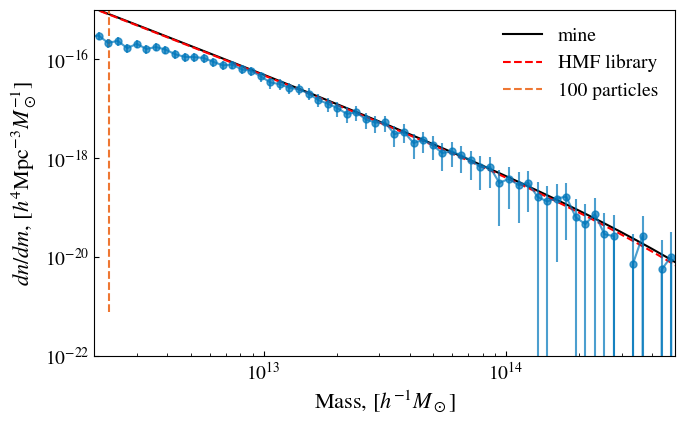

In [25]:
# Plot the reference HMF
plt.figure()
plt.plot(M_list, n_ST_list, color="k", label = "mine")
plt.plot(hmf.m,hmf.dndm, '--', color="red", label="HMF library")
plt.yscale('log')
plt.xscale('log')

###### We compute the histogram of the halo mass for our simulation
bins_hmf=np.logspace(11,16,num=128)
bcen_hmf=0.5*(bins_hmf[1:]+bins_hmf[:-1])
db_hmf=bins_hmf[1:]-bins_hmf[:-1]
# Halo mass function using Hop mass estimate, note that masses must be given in Msol/h
# Note : hop mass is slightly underestimated compared to proper M200 calculation
myhmf,bmf=np.histogram(mh*h,bins=bins_hmf) #<<< msol/h

mydndm_hmf=myhmf/db_hmf/L**3
mydndm1_hmf=mydndm_hmf+3*np.sqrt(myhmf)/db_hmf/L**3 #3 sigma dispersion
mydndm2_hmf=mydndm_hmf-3*np.sqrt(myhmf)/db_hmf/L**3 #3 sigma dispersion


# Plot
# plt.plot(bcen_hmf,mydndm_hmf,'-o',markersize=5,label='hop 256^3 {:5.2f} Mpc/h z={:5.2f}'.format(L,zsnap),alpha=0.3)
# plt.fill_between(bcen_hmf,mydndm1_hmf,mydndm2_hmf,alpha=0.3)

plt.errorbar(bcen_hmf, mydndm_hmf,
    yerr = [mydndm_hmf - mydndm2_hmf,
    mydndm1_hmf - mydndm_hmf],
    fmt='o-', markersize=5, alpha=0.7)

plt.xlabel(r"Mass, $[h^{-1}M_\odot]$")
plt.ylabel(r"$dn/dm$, $[h^{4}{\rm Mpc}^{-3}M_\odot^{-1}]$");
plt.xlim([2e12,5e14])
plt.ylim([1e-22,1e-15])
plt.plot(np.ones(10)*100*mpart*h/2e30,np.linspace(np.min(hmf.dndm),np.max(hmf.dndm),10),'--', label="100 particles")
plt.legend()

## CMF

Our first goal will be to find the number of particles inside a given region

In [26]:
x_mpc = mycmf.norm2dist(x, grid_size)
y_mpc = mycmf.norm2dist(y, grid_size)
z_mpc = mycmf.norm2dist(z, grid_size)
part_pos_mpc = np.column_stack((x_mpc, y_mpc, z_mpc))

xh_mpc = mycmf.norm2dist(xh, grid_size)
yh_mpc = mycmf.norm2dist(yh, grid_size)
zh_mpc = mycmf.norm2dist(zh, grid_size)
halo_pos_mpc = np.column_stack((xh_mpc, yh_mpc, zh_mpc))

# Parameters to choose and simulation

In [27]:
Ncut = 8
shape="sphere"
nbins = 50
M_list = np.logspace(11,16,200) #Msun/h

subreg_list = mycmf.analyze_subregions(Ncut, shape ,grid_size, halo_pos_mpc, part_pos_mpc, mpart, rho_MsunMpc3, mh, kh, pk, M_list, model = "cST", nbins=nbins)

Computing values for 512 spheres of radius 15.30 Mpc...


  0%|          | 0/512 [00:00<?, ?it/s]/home/mesquita/stage/my_hmf_cmf_lib.py:466: RuntimeWarning: invalid value encountered in double_scalars
  fourth_term = sig_camb/delta_sig**(3/2)
 29%|██▉       | 149/512 [02:49<05:18,  1.14it/s]/home/mesquita/stage/my_hmf_cmf_lib.py:469: RuntimeWarning: overflow encountered in exp
  fifth_term = np.exp(exp_argument)
100%|██████████| 512/512 [07:27<00:00,  1.14it/s]

Found 8934278 particles and 3729 halos in 8^3 = 512 spheres of radius/half-width 15.30 Mpc.


In [28]:
delta_NL_paved = [subregion.delta_NL for subregion in subreg_list]
idx_sort_delta_NL = np.argsort(delta_NL_paved)
subreg_sorted = subreg_list[idx_sort_delta_NL]

radius_sr = subreg_sorted[0].radius
delta_NL_paved = [subregion.delta_NL for subregion in subreg_sorted]

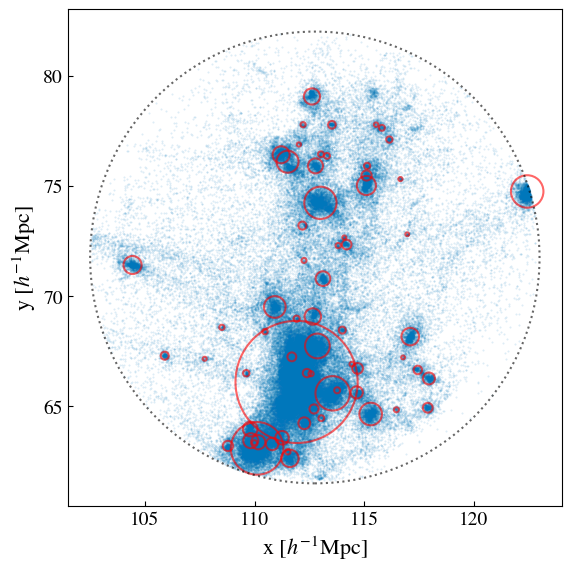

In [29]:
sr_highest_mass = subreg_sorted[-1]

idx_part_in_highest_mass_sr = sr_highest_mass.get_idx_particles_inside(part_pos_mpc)

idx_halo_in_highest_mass_sr = sr_highest_mass.get_idx_particles_inside(halo_pos_mpc)

part_alpha = 0.15
part_size = 0.2

halo_alpha = 0.5
halo_size = 50
halo_color = "red"

fig, ax_xy = plt.subplots(figsize=(6, 6))

size_mh = mh[idx_halo_in_highest_mass_sr] / mh[0] * 10000

ax_xy.scatter(x_mpc[idx_part_in_highest_mass_sr]*h, y_mpc[idx_part_in_highest_mass_sr]*h, alpha=part_alpha, s=part_size,rasterized=True)
ax_xy.scatter([], [], color="#0077BB",  label="Particles")
ax_xy.scatter(xh_mpc[idx_halo_in_highest_mass_sr]*h, yh_mpc[idx_halo_in_highest_mass_sr]*h, alpha=0.6, lw=1.5, s=size_mh, color=halo_color, label="Halos", facecolors='none',
            rasterized=True)

if shape == "sphere":
    circle = plt.Circle((sr_highest_mass.center[0]*h, sr_highest_mass.center[1]*h), radius_sr*h, color='k', alpha=0.6, linestyle='dotted', fill=False, linewidth=1.5)
    ax_xy.add_patch(circle)
elif shape == "cube":
    ax_xy.axvline(sr_highest_mass.center[0] - sr_highest_mass.radius, color='r', linestyle='dotted')
    ax_xy.axvline(sr_highest_mass.center[0] + sr_highest_mass.radius, color='r', linestyle='dotted')
    ax_xy.axhline(sr_highest_mass.center[1] - sr_highest_mass.radius, color='r', linestyle='dotted')
    ax_xy.axhline(sr_highest_mass.center[1] + sr_highest_mass.radius, color='r', linestyle='dotted')

ax_xy.set_xlabel("x [$h^{{-1}}$Mpc]")
ax_xy.set_ylabel("y [$h^{{-1}}$Mpc]")
# ax_xy.set_title(f"$R_0$={radius_sr*h:.2f} $h^{{-1}}$Mpc | $\delta_{{NL}}={sr_highest_mass.delta_NL:.2f}$ | {len(idx_halo_in_highest_mass_sr)} halos")
# ax_xy.legend()
plt.tight_layout()
plt.savefig(f"./saved_results/misc/halos_densest_{nb_iter}.svg", dpi=300, bbox_inches='tight')
plt.show()

# Plot subregions

In [30]:
indiv_range = 0.5
lower_bound = -1
upper_bound = 1.6
dNL_range = np.arange(lower_bound, upper_bound, indiv_range)
count_cut = 128

method_sub_cmf = "range"

In [31]:
if method_sub_cmf == "range":
    arg_sub_cmf = dNL_range
elif method_sub_cmf == "number":
    arg_sub_cmf =  count_cut

print("method is", method_sub_cmf)
print("arg_sub_cmf", arg_sub_cmf)

method is range
arg_sub_cmf [-1.  -0.5  0.   0.5  1.   1.5]


In [32]:
#mycmf.plot_sub_cmf(subreg_sorted, arg_sub_cmf, delta_NL_paved, Ncut, mh, nbins, M_list, method=method_sub_cmf)

In [33]:
#mycmf.plot_every_sub_cmf(subreg_sorted, arg_sub_cmf, delta_NL_paved, Ncut, mh, nbins, M_list, method=method_sub_cmf)

/home/mesquita/stage/my_hmf_cmf_lib.py:1571: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  halos_idx_list = np.array([sr.halo_indices for sr in sr_of_interest if len(sr.halo_indices) > 0])


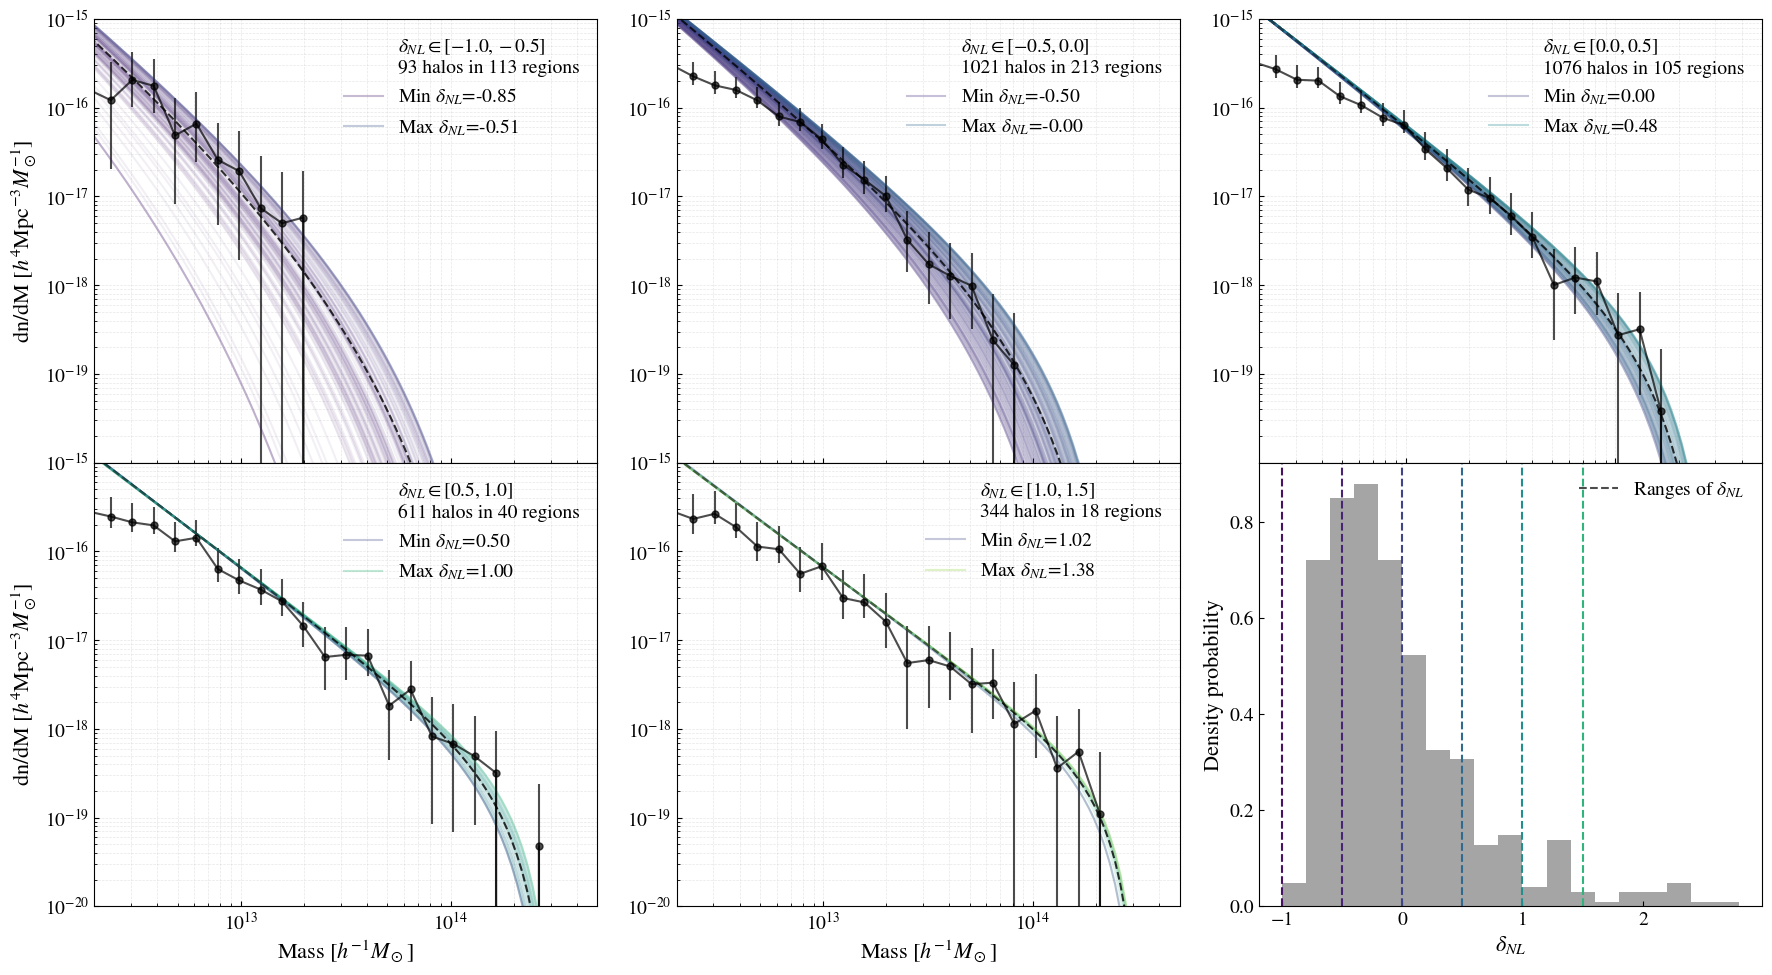

In [ ]:
mycmf.plot_every_sub_cmf2(subreg_sorted, arg_sub_cmf, delta_NL_paved, Ncut, mh, 50, M_list, shape = "sphere", z=zsnap, showfig=True)

The results show that the average CMF of the subregions closely matches the empirical data at intermediate and high masses, with a deviation at low masses as expected. This confirms that Dyablo correctly forms dark matter halos and allows us to predict their distribution across environments defined by overdensity.

# fcoll

Fraction of mass collapsed in a region

$f_{coll} = \frac{M_{collapsed}}{M_{region}}$

In [35]:
radius_sr_h = radius_sr * h #Mpc/h

In [36]:
hmf_over_bins = [mycmf.hmfcalc(bcen_hmf[i], kh, pk, "ST") for i in range(len(bcen_hmf))]
Mmin = mycmf.Mmin_finder(bcen_hmf, mydndm1_hmf, mydndm2_hmf, hmf_over_bins) #Msun/h

In [37]:
print(f"Mmin = {Mmin:.2e} Msun/h")

Mmin = 7.42e+12 Msun/h


In [39]:
fcoll_emp, delta_NL_filter = mycmf.compute_fcoll_emp(subreg_sorted, Mmin, mh , mpart)

In [40]:
fcoll_th, delta_NL_filter = mycmf.compute_fcoll_th(subreg_sorted, Mmin, kh ,pk, mh, mpart)

Warning! fcoll < 0 for Mcoll = -9.65e+01 Msun/h


/tmp/ipykernel_2218600/3782268804.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)


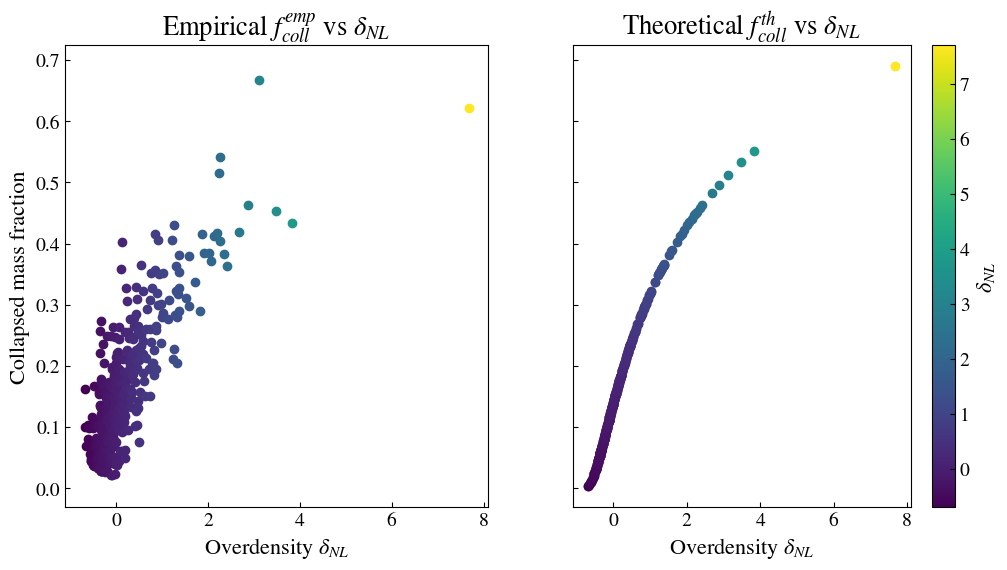

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

cmap = cm.viridis
norm = plt.Normalize(vmin=np.round(delta_NL_filter[0], 1), vmax=np.round(delta_NL_filter[-1], 1))
color = cmap(norm(delta_NL_filter))

for i in range(len(fcoll_emp)):
    ax[0].scatter(delta_NL_filter[i], fcoll_emp[i], color=color[i], alpha=1)
ax[0].set_xlabel(r"Overdensity $\delta_{NL}$")
ax[0].set_ylabel(r"Collapsed mass fraction")
ax[0].set_title(r"Empirical $f_{coll}^{emp}$ vs $\delta_{NL}$")

for i in range(len(delta_NL_filter)):
    ax[1].scatter(delta_NL_filter[i], fcoll_th[i], color=color[i], alpha=1)
ax[1].set_xlabel(r"Overdensity $\delta_{NL}$")
ax[1].set_title(r"Theoretical $f_{coll}^{th}$ vs $\delta_{NL}$")

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm)
cbar.set_label(r'$\delta_{NL}$')

plt.show()

/tmp/ipykernel_2218600/2079744660.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


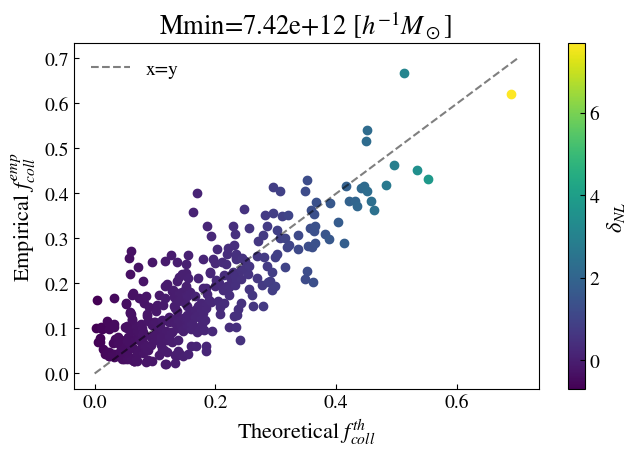

In [42]:
cmap = cm.viridis

norm = plt.Normalize(vmin=np.round(delta_NL_filter[0],1), vmax=np.round(delta_NL_filter[-1],1))
color = cmap(norm(delta_NL_filter))

plt.plot(np.linspace(0,0.7,100), np.linspace(0,0.7,100), '--', color="black", alpha=0.5, label="x=y")

for i in range(len(fcoll_emp)):
    plt.scatter(fcoll_th[i], fcoll_emp[i], color=color[i], alpha=1)

    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label(f'$\delta_{{NL}}$')

# plt.xlim(0, 0.7)
# plt.ylim(0,0.7)

plt.xlabel(r"Theoretical $f_{coll}^{th}$")
plt.ylabel(r"Empirical $f_{coll}^{emp}$")
plt.title(f"Mmin={Mmin:.2e} $[h^{{-1}}M_\odot]$")
plt.legend()
plt.show()

While the markers are not exactly on the $x=y$ line, we can still the trend to follow this line, they are no persistent under or overestimation by the simulation.

### Fraction of the mass we miss

In [43]:
mh_below = mh[mh < Mmin/h]

mass_missed = np.sum(mh_below)/np.sum(mh)

print("Mass missed :",mass_missed*100,"% with ", len(mh_below), "halos out of ", len(mh), "halos. Ratio of halos missed to halos found is ", len(mh_below)/len(mh)*100, "%")

Mass missed : 17.40455453397556 % with  4561 halos out of  7084 halos. Ratio of halos missed to halos found is  64.3845285149633 %


### Plotting the subregion with the highest mass

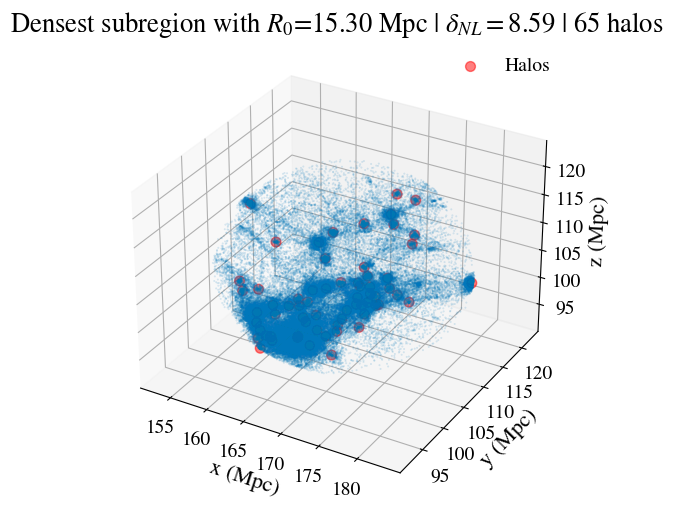

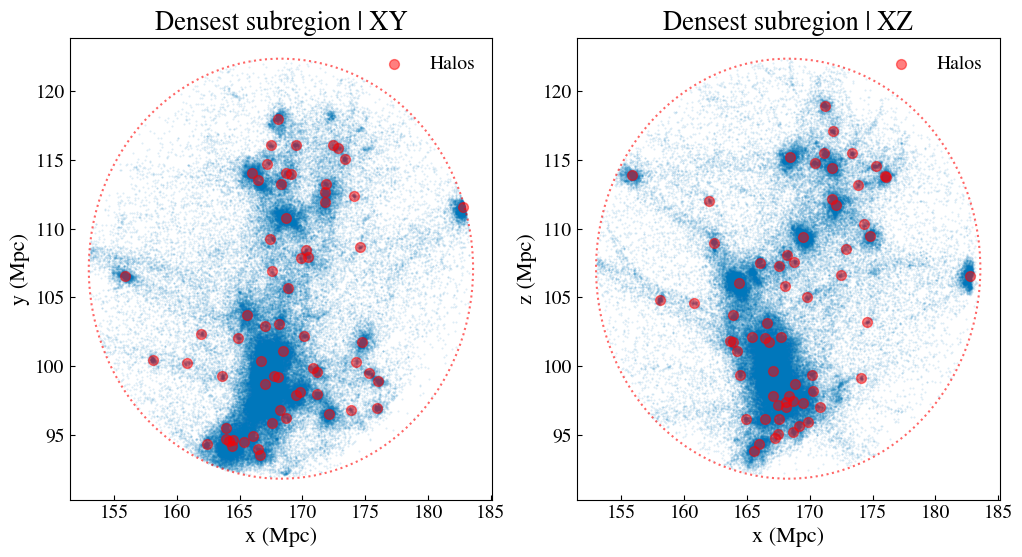

In [44]:
sr_highest_mass = subreg_sorted[-1]

idx_part_in_highest_mass_sr = sr_highest_mass.get_idx_particles_inside(part_pos_mpc)

idx_halo_in_highest_mass_sr = sr_highest_mass.get_idx_particles_inside(halo_pos_mpc)

part_alpha = 0.15
part_size = 0.2

halo_alpha = 0.5
halo_size = 50
halo_color = "red"

fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.scatter(x_mpc[idx_part_in_highest_mass_sr], y_mpc[idx_part_in_highest_mass_sr], z_mpc[idx_part_in_highest_mass_sr], alpha=part_alpha, s=part_size)
ax.scatter(xh_mpc[idx_halo_in_highest_mass_sr], yh_mpc[idx_halo_in_highest_mass_sr], zh_mpc[idx_halo_in_highest_mass_sr], alpha=0.5, s=halo_size, color=halo_color, label = "Halos")
ax.set_xlabel("x (Mpc)")
ax.set_ylabel("y (Mpc)")
ax.set_zlabel("z (Mpc)")
ax.set_title(f"Densest subregion with $R_0$={radius_sr:.2f} Mpc | $\delta_{{NL}}={sr_highest_mass.delta_NL:.2f}$ | {len(idx_halo_in_highest_mass_sr)} halos")
ax.legend()

fig, (ax_xy, ax_xz) = plt.subplots(1, 2, figsize=(12, 6))

ax_xy.scatter(x_mpc[idx_part_in_highest_mass_sr], y_mpc[idx_part_in_highest_mass_sr], alpha=part_alpha, s=part_size)
ax_xy.scatter(xh_mpc[idx_halo_in_highest_mass_sr], yh_mpc[idx_halo_in_highest_mass_sr], alpha=halo_alpha, s=halo_size, color=halo_color, label = "Halos")

if shape == "sphere":
    circle = plt.Circle((sr_highest_mass.center[0], sr_highest_mass.center[1]), radius_sr, color='r',  alpha = 0.6, linestyle='dotted', fill=False, linewidth=1.5)
    ax_xy.add_patch(circle)
elif shape == "cube":
    ax_xy.axvline(sr_highest_mass.center[0] - sr_highest_mass.radius, color='r', linestyle='dotted')
    ax_xy.axvline(sr_highest_mass.center[0] + sr_highest_mass.radius, color='r', linestyle='dotted')
    ax_xy.axhline(sr_highest_mass.center[1] - sr_highest_mass.radius, color='r', linestyle='dotted')
    ax_xy.axhline(sr_highest_mass.center[1] + sr_highest_mass.radius, color='r', linestyle='dotted')
    
ax_xy.set_xlabel("x (Mpc)")
ax_xy.set_ylabel("y (Mpc)")
ax_xy.set_title(f"Densest subregion | XY")
ax_xy.legend()


ax_xz.scatter(x_mpc[idx_part_in_highest_mass_sr], z_mpc[idx_part_in_highest_mass_sr], alpha=part_alpha, s=part_size)
ax_xz.scatter(xh_mpc[idx_halo_in_highest_mass_sr], zh_mpc[idx_halo_in_highest_mass_sr], alpha=halo_alpha, s=halo_size, color=halo_color, label = "Halos")
if shape == "sphere":
    circle = plt.Circle((sr_highest_mass.center[0], sr_highest_mass.center[2]), radius_sr, color='r',  alpha = 0.6, linestyle='dotted', fill=False, linewidth=1.5)
    ax_xz.add_patch(circle)
elif shape == "cube":
    ax_xz.axvline(sr_highest_mass.center[0] - sr_highest_mass.radius, color='r', linestyle='dotted')
    ax_xz.axvline(sr_highest_mass.center[0] + sr_highest_mass.radius, color='r', linestyle='dotted')
    ax_xz.axhline(sr_highest_mass.center[1] - sr_highest_mass.radius, color='r', linestyle='dotted')
    ax_xz.axhline(sr_highest_mass.center[1] + sr_highest_mass.radius, color='r', linestyle='dotted')
ax_xz.set_xlabel("x (Mpc)")
ax_xz.set_ylabel("z (Mpc)")
ax_xz.set_title(f"Densest subregion | XZ")
ax_xz.legend()

plt.show()

# R200 utils

Radius around the center of a halo within which the average density is 200 times the mean density of the universe.

I did not use that but it's here just in case

In [45]:
def linear_overdensity(center_sphere, radius_sphere, grid_size, part_pos_mpc,  rho_mean):
    rho = mycmf.density_in_shape(center_sphere, radius_sphere, grid_size, part_pos_mpc)
    delta_NL = rho / rho_mean
    delta_L = mycmf.compute_delta_linear(delta_NL)
    return delta_L

def compute_dist_from_center(center_sphere, grid_size, pos_mpc):
    cx, cy, cz = center_sphere
    x, y, z = pos_mpc[:,0], pos_mpc[:,1], pos_mpc[:,2]
    xsize, ysize, zsize = grid_size
    
    dx = np.minimum(abs(x - cx), xsize - abs(x - cx)) #either normal distance or substracting the grid_size 
    dy = np.minimum(abs(y - cy), ysize - abs(y - cy))
    dz = np.minimum(abs(z - cz), zsize - abs(z - cz))
    
    d = np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)
    
    return d

In [46]:
def compute_R200_mine(halo_idx, R200_init, grid_size, part_pos_mpc, rho_mean, print_convergence = True):
    halo_pos = [xh_mpc[halo_idx], yh_mpc[halo_idx], zh_mpc[halo_idx]]
    halo_mass = mh[halo_idx] #Msun
    R200 = R200_init #Mpc
    R200_max = R200
    R200_min = 1e-3

    parts_in_halo = mycmf.idx_of_part_in_shape(halo_pos, R200, grid_size, part_pos_mpc)
    delta_L = linear_overdensity(halo_pos, R200, grid_size, part_pos_mpc, rho_mean)
    print(f"Computing the R200 of the halo of center {np.round(halo_pos,0)} and mass {halo_mass:.2e} Msun...")
    
    while abs(delta_L - 200) > 5e-2:
        if print_convergence:
            print(f"Current overdensity of {delta_L:.2f} with a R200 = {R200:.2f} Mpc and with {len(parts_in_halo)} particles in it.")
        # R200= R200 / 2
        if delta_L < 200:
            R200_max = R200
        else:
            R200_min = R200
        
        R200 = (R200_max + R200_min) / 2  

        parts_in_halo = mycmf.idx_of_part_in_shape(halo_pos, R200, grid_size, part_pos_mpc)
        delta_L = linear_overdensity(halo_pos, R200, grid_size, part_pos_mpc, rho_mean)
    print(f"Convergence over ! Overdensity of : {delta_L:.1f}.")
    print(f"Halo of center {np.round(halo_pos,0)} and mass {halo_mass:.2e} Msun has a R200 of {R200:.2f} Mpc with {len(parts_in_halo)} particles in it.")
    return R200

In [47]:
def compute_R200(halo_idx, R200_init, grid_size, part_pos_mpc, rho_mean, mpart=mpart):
    halo_pos = [xh_mpc[halo_idx], yh_mpc[halo_idx], zh_mpc[halo_idx]]
    nb_part_init = mycmf.idx_of_part_in_shape(halo_pos, R200_init, grid_size, part_pos_mpc)
    
    ri = compute_dist_from_center(halo_pos, grid_size, part_pos_mpc[nb_part_init])
    ri_sorted = np.sort(ri)
    
    N = np.array([i for i in range(1,len(nb_part_init)+1)])
    
    rho_region = mpart/2e30 * N / (4/3*np.pi*ri_sorted**3)
    rho_quotient = rho_region / rho_mean
    
    below_200 = np.where(rho_quotient < 200)[0]
    
    if len(below_200) == 0 :
        print("No R200 found with this R200_init, increasing R200_init...")
        R200 = compute_R200(halo_idx, 2*R200_init, grid_size, part_pos_mpc, rho_mean, mpart=mpart)
        return R200
    
    R200 = ri_sorted[below_200[0]]
    
    return R200

In [48]:
halo_of_interest = 0
R200init = 10 #Mpc
halo_center = [xh_mpc[halo_of_interest], yh_mpc[halo_of_interest], zh_mpc[halo_of_interest]]

R200test = compute_R200(halo_of_interest, R200init, grid_size, part_pos_mpc, rho_MsunMpc3)

In [49]:
print(compute_R200(halo_of_interest, R200init, grid_size, part_pos_mpc, rho_MsunMpc3))

4.4013968


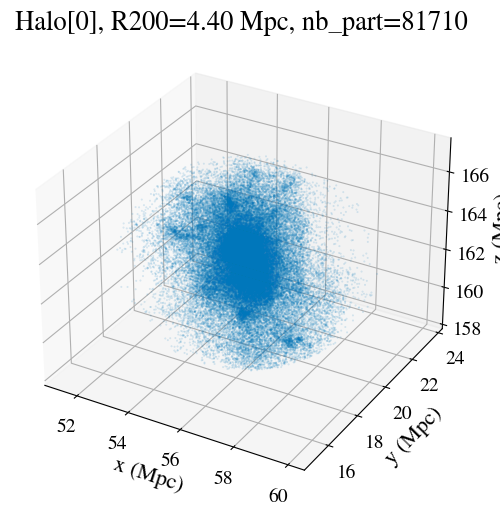

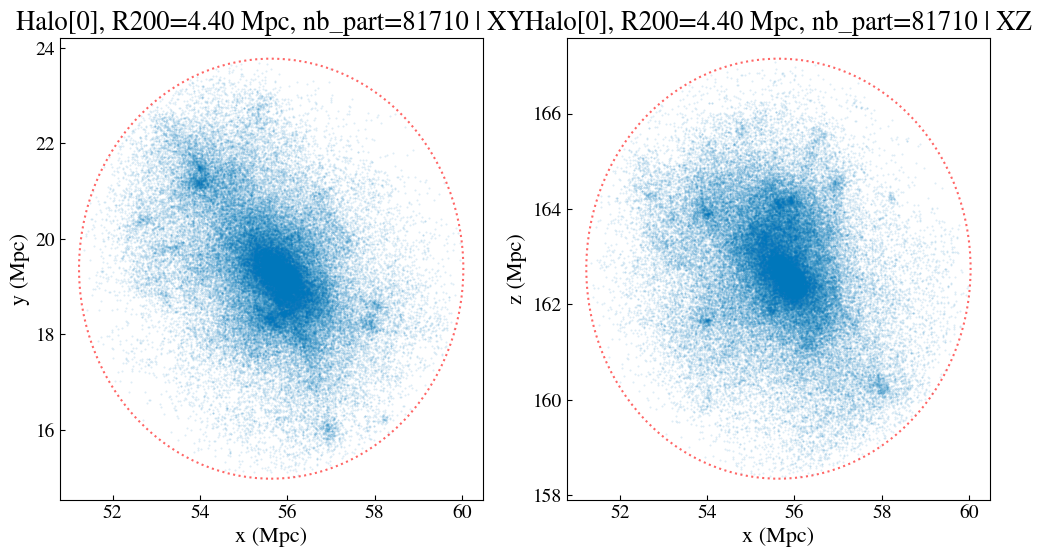

In [50]:
idx_part_in_HOI = mycmf.idx_of_part_in_shape(halo_center, R200test, grid_size, part_pos_mpc)
part_alpha = 0.15
part_size = 0.2


fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.scatter(x_mpc[idx_part_in_HOI], y_mpc[idx_part_in_HOI], z_mpc[idx_part_in_HOI], alpha=part_alpha, s=part_size)
ax.set_xlabel("x (Mpc)")
ax.set_ylabel("y (Mpc)")
ax.set_zlabel("z (Mpc)")
ax.set_title(f"Halo[{halo_of_interest}], R200={R200test:.2f} Mpc, nb_part={len(idx_part_in_HOI)}")

fig, (ax_xy, ax_xz) = plt.subplots(1, 2, figsize=(12, 6))

ax_xy.scatter(x_mpc[idx_part_in_HOI], y_mpc[idx_part_in_HOI], alpha=part_alpha, s=part_size)
circle = plt.Circle((halo_center[0], halo_center[1]), R200test, color='r',  alpha = 0.6, linestyle='dotted', fill=False, linewidth=1.5)
ax_xy.add_patch(circle)
ax_xy.set_xlabel("x (Mpc)")
ax_xy.set_ylabel("y (Mpc)")
ax_xy.set_title(f"Halo[{halo_of_interest}], R200={R200test:.2f} Mpc, nb_part={len(idx_part_in_HOI)} | XY")

ax_xz.scatter(x_mpc[idx_part_in_HOI], z_mpc[idx_part_in_HOI], alpha=part_alpha, s=part_size)
circle = plt.Circle((halo_center[0], halo_center[2]), R200test, color='r',  alpha = 0.6, linestyle='dotted', fill=False, linewidth=1.5)
ax_xz.add_patch(circle)
ax_xz.set_xlabel("x (Mpc)")
ax_xz.set_ylabel("z (Mpc)")
ax_xz.set_title(f"Halo[{halo_of_interest}], R200={R200test:.2f} Mpc, nb_part={len(idx_part_in_HOI)} | XZ")

plt.show()